In [1]:
%matplotlib widget

In [12]:
import sys
sys.path.append('../..')
from lcs import SRC_ROOT
from pathlib import Path
import matplotlib.pyplot as plt
import jax
import numpy as np
from lcs.configs import Config
from run_script import get_data
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from lcs import TEXTWIDTH, PAGEHEIGHT
from lcs.plotting_utils import *
import copy

In [4]:
cfg = Config(input_size=20,
       output_size=10,
       num_seeds=10, 
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       regularization_strength=0.22,
       num_layers=2,
       hidden_size=10,
       context_model=False,
       name='gated_FC',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L2', 10.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=None,
       W_teachers='generate',
       use_X=True,
       metric='cosine',
       teacher_mode='orthogonal',
       num_blocks=30,
       t_tot=30,
       T_tot=1000,
       block_duration=1.0,
       W1_tau=0.06, 
       W2_tau=0.01,
       dt=0.01,
       log_every=1,
       T_tape=10000,
       dt_tape=0.01,
       control='deep_mono',
       data_out_dir='data_internal/gating_FC/',
       results_out_dir='results_internal/gating_FC/',
       num_shared_contexts=0,
       mixing_factor=0.5,
       W_regularization_strength=0.0,
       turn_off_regularization=False,
       log_aux=False,
        )
tape, args = get_data(cfg)

[WARNING] [2024-10-08 09:54:20,891] in lcs.configs: Using a dt > 1e-3 introduces finite-size effects!


In [42]:
last_c_idx_1 = np.where(tape.current_context[0] == 0)[0][-1]
last_c_idx_2 = np.where(tape.current_context[0] == 1)[0][-1] 
seed = 0

# sorted W2 for one seed (for task A (C1) and task B (C2)) (Fig. 6, panel A)
# C1 = np.concatenate((tape.sorted_W2_student[seed, last_c_idx_1][0], tape.sorted_W2_student[seed, last_c_idx_1][1]), axis=1)
# C2 = np.concatenate((tape.sorted_W2_student[seed, last_c_idx_2][0], tape.sorted_W2_student[seed, last_c_idx_2][1]), axis=1)

# unsorted W2 for one seed (Fig. A5, panel A)
# C1 = tape.W2[seed, last_c_idx_1]
# C2 = tape.W2[seed, last_c_idx_2]

# mean sorted W2 over all seeds (Fig. A6, panel A)
C1 = np.mean(np.concatenate((tape.sorted_W2_student[:, last_c_idx_1][:,0], tape.sorted_W2_student[:, last_c_idx_1][:,1]), axis=2), axis=0)
C2 = np.mean(np.concatenate((tape.sorted_W2_student[:, last_c_idx_2][:,0], tape.sorted_W2_student[:, last_c_idx_2][:,1]), axis=2), axis=0)

In [43]:
s = 2
fig = plt.figure(figsize=(s*TEXTWIDTH*.4, s*PAGEHEIGHT*0.2), layout='constrained')
axd = fig.subplots(nrows=2, ncols=1)

for ax in axd.flat: 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

vmin = 0
vmax = 0.5

cmap = matplotlib.colormaps['Oranges']
normalizer = Normalize(vmin, vmax)
im = cm.ScalarMappable(cmap=cmap, norm=normalizer)

ax = axd.flat[0]
im1 = ax.imshow(C1, cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_title('Task A')
ax.set_yticks([])
ax.set_xticks([])

ax = axd.flat[1]
im2 = ax.imshow(C2, cmap=cmap, vmin=vmin, vmax=vmax) 
ax.set_title('Task B')
ax.set_yticks([])
ax.set_xticks([])

fig.colorbar(im, ax=axd.ravel().tolist(), shrink=0.7, ticks = [0, 0.5], label='parameter value')

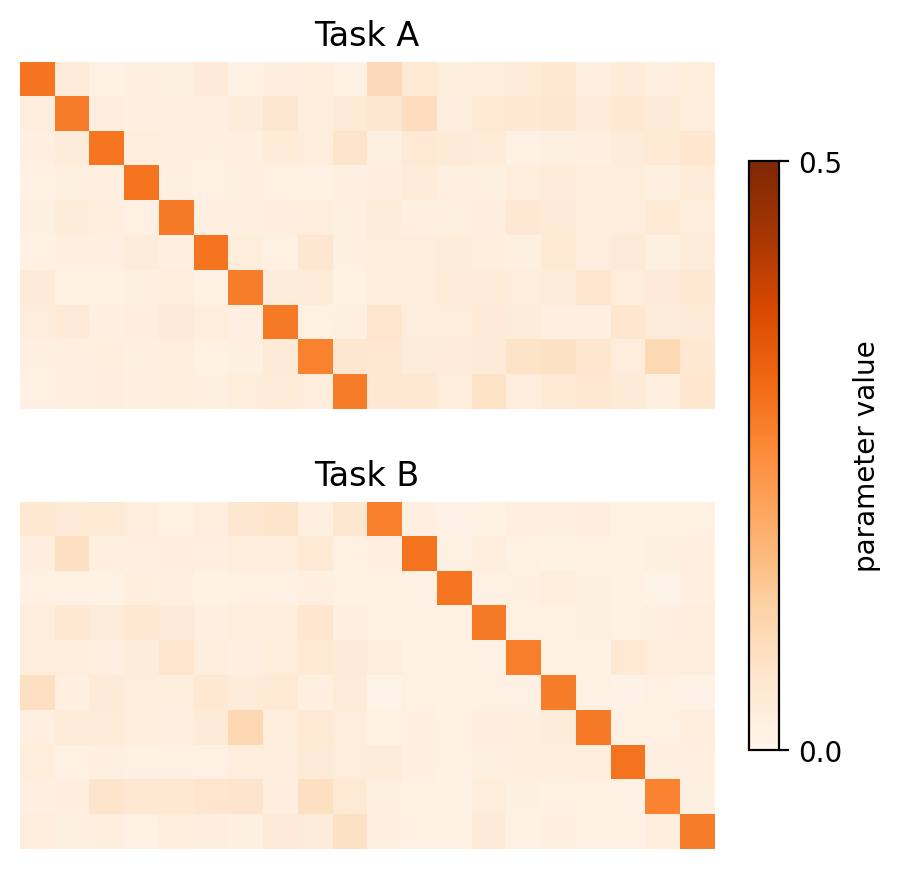

In [44]:
fig

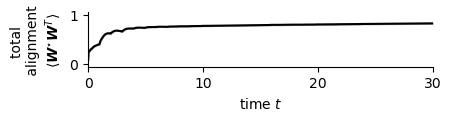

In [21]:
# student-teacher total alignment over all seeds (Fig. 6, panel B)
s = 2
fig = plt.figure(figsize=(s*TEXTWIDTH*.4, s*PAGEHEIGHT*0.05), layout='constrained')

axd = fig.subplots(nrows=1, ncols=1)

axd.spines['right'].set_visible(False)
axd.spines['top'].set_visible(False)

t = np.atleast_1d(tape.t).mean(0)

fill_between(axd, t, tape.concat_cossim, color="k", alpha=1) 
axd.dataLim.y0 = 0 
axd.dataLim.y1 = 1 
axd.set_ylabel('total \n alignment \n' + r'$\langle \boldsymbol{W}^{\star} \boldsymbol{W}^{T}\rangle$')
axd.set_xlabel(r'time $t$')
axd.set_xlim(0, tape.t.max())
axd.set_xticks([0, 10, 20, 30])

fig

In [13]:
# forgetful (non-gating) FC model comparison
forget_cfg = copy.deepcopy(cfg)
forget_cfg.regularization_strength = 0
forget_cfg.name = 'forget_FC'
forget_tape, forget_args = get_data(forget_cfg)

[WARNING] [2025-02-19 19:35:22,086] in lcs.configs: Using a dt > 1e-3 introduces finite-size effects!
[INFO] [2025-02-19 19:35:22,238] in lcs.joint_learning: Running 10 seeds on device TFRT_CPU_0 with config Config(input_size=20,
       output_size=10,
       num_seeds=10,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0,
       num_layers=2,
       hidden_size=10,
       context_model=False,
       name='forget_FC',
       regularization_type=[('nonnegative', 1), ('gating_manifold_L2', 10.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=None,
       use_X=True,
       metric='cosine',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       teacher_scale='d_in',
       teacher_rotate=True,
       t_tot=30,
       T_tot=3000,
       num_blocks=31,
       block_duratio

In [45]:
forget_last_c_idx_1 = np.where(forget_tape.current_context[0] == 0)[0][-1]
forget_last_c_idx_2 = np.where(forget_tape.current_context[0] == 1)[0][-1]
seed = 0

# mean sorted W2 over all seeds (Fig. A6, panel B)
forget_C1 = np.mean(np.concatenate((forget_tape.sorted_W2_student[:, forget_last_c_idx_1][:,0], forget_tape.sorted_W2_student[:, forget_last_c_idx_1][:,1]), axis=2), axis=0)
forget_C2 = np.mean(np.concatenate((forget_tape.sorted_W2_student[:, forget_last_c_idx_2][:,0], forget_tape.sorted_W2_student[:, forget_last_c_idx_2][:,1]), axis=2), axis=0)

# unsorted W2 for one seed (Fig. A5, panel B)
# forget_C1 = forget_tape.W2[seed, forget_last_c_idx_1]
# forget_C2 = forget_tape.W2[seed, forget_last_c_idx_2]

In [49]:
s = 2
fig = plt.figure(figsize=(s*TEXTWIDTH*.4, s*PAGEHEIGHT*0.2), layout='constrained')

axd = fig.subplots(nrows=2, ncols=1)

for ax in axd.flat:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

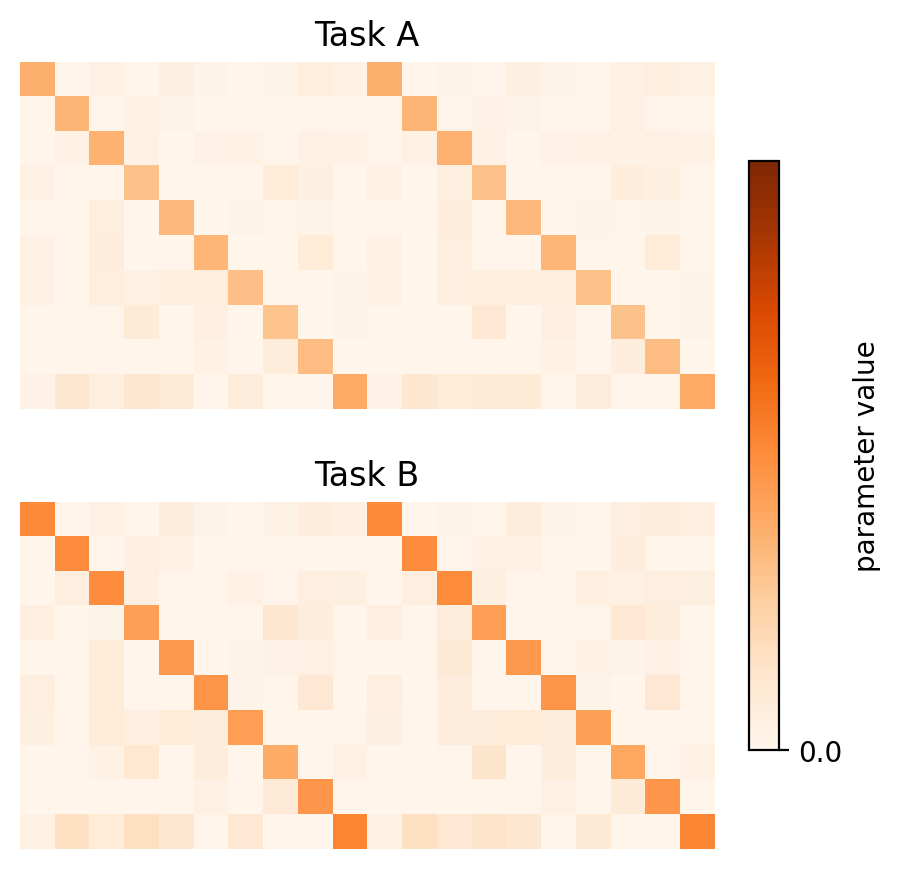

In [50]:
vmin = 0
vmax = 0.5

cmap = matplotlib.colormaps['Oranges']
normalizer = Normalize(vmin, vmax)
im = cm.ScalarMappable(cmap=cmap, norm=normalizer)

ax = axd.flat[0] 
im1 = ax.imshow(forget_C1, cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_title('Task A')
ax.set_yticks([])
ax.set_xticks([])

ax = axd.flat[1] 
im2 = ax.imshow(forget_C2, cmap=cmap, vmin=vmin, vmax=vmax) 
ax.set_title('Task B')
ax.set_yticks([])
ax.set_xticks([])

fig.colorbar(im, ax=axd.ravel().tolist(), shrink=0.7, ticks = [0, 0.7], label='parameter value')
fig